In [ ]:
import re
import warnings
import duckdb

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl

from typing import List
from scipy import integrate
from datetime import datetime, time, timedelta

from matplotlib import pyplot as plt
from matplotlib import font_manager as fm

warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
FIGSIZE_ACM_SMALL = (3.33, 2.06)
FIGSIZE_ACM_LARGE = (7.00, 2.06)

flare = sns.color_palette("flare", 4)
colors = [flare[3], flare[1]]

sns.reset_defaults()
pd.options.display.float_format = '{:.5f}'.format
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Linux Libertine"],
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{libertine}",
    "mathtext.fontset": "custom",
    "mathtext.rm": "Linux Libertine",
    "mathtext.it": "Linux Libertine:italic",
    "mathtext.bf": "Linux Libertine:bold",
})

plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 10
})


Für `data_static` Pi 5 rausfiltern, für `data_dynamic` Nummer 2 (?) rausfiltern

In [ ]:
def data_consumption(kind: str, melt: bool, raw: bool = False) -> pd.DataFrame:

    data = []
    with open(f"./data_{kind}/pi0/{kind}/consumption.log") as f:
        for line in f:
            data.append(re.findall(r"([-+]?\d*\.\d+|\d+)", line))
    df = pd.DataFrame(data=data, columns=["time", "V1", "A1", "V2", "A2", "V3", "A3", "V4", "A4", "V5", "A5"])
    
    df["time"] = df["time"].astype(np.float64)
    for i in range(1,6):
        df[f"W{i}"] = df[f"V{i}"].astype(np.float64) * df[f"A{i}"].astype(np.float64)

    if raw:
        return df

    if melt:
        df = pd.melt(df, id_vars="time", value_vars=[f"W{i}" for i in range(1, 6)], var_name="pi", value_name="W")
        label_map = {"W1": "1", "W2": "2", "W3": "3", "W4": "4", "W5": "5"}
        df["pi"] = df["pi"].replace(label_map)
    
    else:
        df["W"] = df["W1"] + df["W2"] + df["W3"] + df["W4"] + df["W5"]
        df = df.drop(["V1", "A1", "V2", "A2", "V3", "A3", "V4", "A4", "V5", "A5", "W1", "W2", "W3", "W4", "W5"], axis=1)
        
        df["time"] = pd.to_datetime(df["time"], unit="s")
        df = df.set_index("time")
        df = df.resample("1S").mean()
        df = df.reset_index(False)
        
        df["time"] = pd.to_numeric(df["time"])/10**9
        df["time"] = df["time"].astype(int)
        df["time"] = df["time"] - df["time"].min()
        
        df = df.dropna(subset=["W"])
        df["W"] = df["W"].interpolate()

    return df

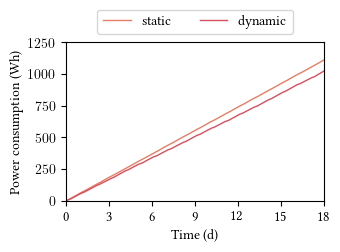

In [ ]:
data_dynamic = data_consumption("dynamic", False)
data_dynamic["J"] = integrate.cumulative_trapezoid(y=data_dynamic["W"], x=data_dynamic["time"], initial=0)
data_dynamic["Wh"] = data_dynamic["J"]/3_600

data_static = data_consumption("static", False)
data_static["J"] = integrate.cumulative_trapezoid(y=data_static["W"], x=data_static["time"], initial=0)
data_static["Wh"] = data_static["J"]/3_600

def plot_consumption_cluster_total(data_static: pd.DataFrame, data_dynamic: pd.DataFrame, colors: list) -> None:

    fig, ax = plt.subplots(figsize=FIGSIZE_ACM_SMALL)

    sns.lineplot(x="time", y="Wh", data=data_static, ax=ax, label="static", color=colors[0], linewidth=1)
    sns.lineplot(x="time", y="Wh", data=data_dynamic, ax=ax, label="dynamic", color=colors[1], linewidth=1)

    #plt.fill_between(
    #    x=data_static["time"], 
    #    y1=data_static["Wh"], 
    #    y2=data_dynamic["Wh"][:len(data_static["Wh"])], 
    #    color="green", alpha=0.25
    #)
    
    xlim = 86_400 * 3
    ax.set_xlabel("Time (d)")
    ax.set_xlim(0, xlim)
    ax.set_xticks(
        ticks=range(0, xlim+1, xlim//6),
        labels=range(0, 18+1, 3)
    )

    ylim = 1250
    ax.set_ylabel("Power consumption (Wh)")
    ax.set_ylim(0, ylim)

    ax.grid(False)

    ax.legend(
        loc="upper center",
        ncols=2,
        bbox_to_anchor=(0.5, 1.25),
        reverse = False,
        frameon = True,
        fancybox = True,
    )

    plt.show()
    #fig.savefig("../2025-paper-HaveYouTriedTurningItOff/graphs/consumption_cluster_total.pdf", bbox_inches="tight")
    plt.close()

plot_consumption_cluster_total(data_static, data_dynamic, colors=colors)

In [ ]:
dfs = data_consumption(kind="static", melt=False, raw=True)
dfs["nodes_active"] = (dfs["W1"] != 0).astype(np.int64) + (dfs["W2"] != 0) + (dfs["W3"] != 0) + (dfs["W4"] != 0) + (dfs["W5"] != 0)
dfs["nodes_active_scaled"] = dfs["nodes_active"] * 5
dfs["W"] = dfs["W1"] + dfs["W2"] + dfs["W3"] + dfs["W4"] + dfs["W5"]
dfs["time"] = dfs["time"]-dfs["time"].min()

dfd = data_consumption(kind="dynamic", melt=False, raw=True)
dfd["nodes_active"] = (dfd["W1"] != 0).astype(np.int64) + (dfd["W2"] != 0) + (dfd["W3"] != 0) + (dfd["W4"] != 0) + (dfd["W5"] != 0)
dfd["nodes_active_scaled"] = dfd["nodes_active"] * 5
dfd["W"] = dfd["W1"] + dfd["W2"] + dfd["W3"] + dfd["W4"] + dfd["W5"]
dfd["time"] = dfd["time"]-dfd["time"].min()

def plot_power_draw_24h(df: pd.DataFrame, colors: list, filename: str) -> None:

    fig, ax1 = plt.subplots(figsize=FIGSIZE_ACM_SMALL)
    ax2 = ax1.twinx()

    sns.lineplot(x="time", y="W", data=df, ax=ax1, linestyle="-", color=colors[0], label="power", linewidth=1)
    sns.lineplot(x="time", y="nodes_active_scaled", data=df, ax=ax1, linestyle="-", color=colors[1], label="nodes", linewidth=1)
    
    ax1.set_ylabel("Power (W)")
    ax1.set_ylim(0, 25)

    ax2.set_ylabel("Active nodes")
    ax2.set_ylim(0, 5)

    xlim = 86_400 // 6
    ax1.set_xlabel("Time (h)")
    ax1.set_xlim(xlim, xlim*2)
    ax1.set_xticks(
        ticks=range(xlim, 2*xlim+1, xlim//6),
        labels=range(0, 24+1, 4)
    )
    
    ax1.legend(
        loc="upper center",
        ncols=2,
        bbox_to_anchor=(0.5, 1.25),
        reverse = False,
        frameon = True,
        fancybox = True,
    )
    
    fig.savefig(filename, bbox_inches="tight")
    plt.close()

plot_power_draw_24h(dfs, colors, "power_draw_24h_static.pdf")
plot_power_draw_24h(dfd, colors, "power_draw_24h_dynamic.pdf")

In [ ]:
def data_invocations(kind: str) -> pd.DataFrame:

    def start_stop(line: str) -> (str, str):
        line = line.strip()
        contents = line.split(", ")
        contents = contents[1:]
        start, stop = contents[0].split(".")[0], contents[1].split(".")[0]
        return start, stop
    
    base_date = datetime.strptime("1970-01-01", "%Y-%m-%d").date()
    data = []
    for i in range(4):
        start_date = base_date
        last_start = None
        with open(f"./data_{kind}/pi{i}/{kind}/fn_invocations.log") as f:
            counter = 0
            for line in f:
                start, stop = start_stop(line)
                if last_start and int(last_start[:2]) == 23 and int(start[:2]) == 0:
                    start_date += timedelta(days=1)
                date_stop = start_date
                if int(start[:2]) > int(stop[:2]):
                    date_stop += timedelta(days=1)
                t_start = datetime.strptime(f"{start_date} {start}", "%Y-%m-%d %H:%M:%S")
                t_stop = datetime.strptime(f"{date_stop} {stop}", "%Y-%m-%d %H:%M:%S")
                data.append([int(t_start.timestamp()), int(t_stop.timestamp()), i])
                last_start = start
                counter += 1
    return pd.DataFrame(data=data, columns=["time_start", "time_stop", "pi"])

In [ ]:
data_invocations("dynamic").head()

,time_start,time_stop,pi
0,59797,59805,0
1,59797,59805,0
2,59799,59808,0
3,59799,59808,0
4,59800,59810,0


259203 312221


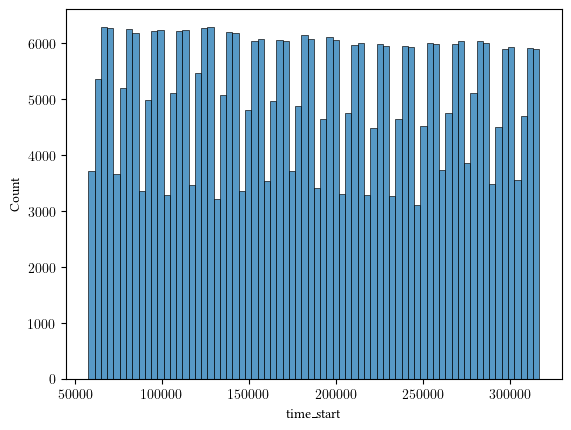

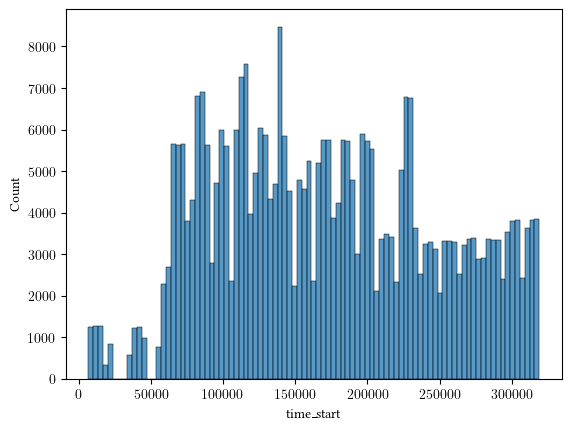

In [ ]:
bucket_size = "1s"

dfs = data_invocations("static")
#dfs["time"] = pd.to_datetime(dfs["time_start"], unit="s")
#dfs["time"] = dfs["time"].dt.floor(bucket_size)
#dfs["time"] = (dfs["time"] - dfs["time"].min()).dt.total_seconds().astype(int)
#dfs = dfs.groupby(["time"]).size().reset_index(name="count")

dfd = data_invocations("dynamic")
#dfd["time"] = pd.to_datetime(dfd["time_start"], unit="s")
#dfd["time"] = dfd["time"].dt.floor(bucket_size)
#dfd["time"] = (dfd["time"] - dfd["time"].min()).dt.total_seconds().astype(int)
#dfd = dfd.groupby(["time"]).size().reset_index(name="count")

print(dfs["time_start"].max()-dfs["time_start"].min(), dfd["time_start"].max()-dfd["time_start"].min())

sns.histplot(dfs["time_start"])
plt.show()
sns.histplot(dfd["time_start"])
plt.show()


#fig, ax = plt.subplots(figsize=FIGSIZE_ACM_LARGE)

#print(len(dfs), len(dfd))

#sns.lineplot(x="time", y="count", data=dfd, ax=ax, label="dynamic")
#sns.lineplot(x="time", y="count", data=dfs, ax=ax, label="static")

#plt.show()

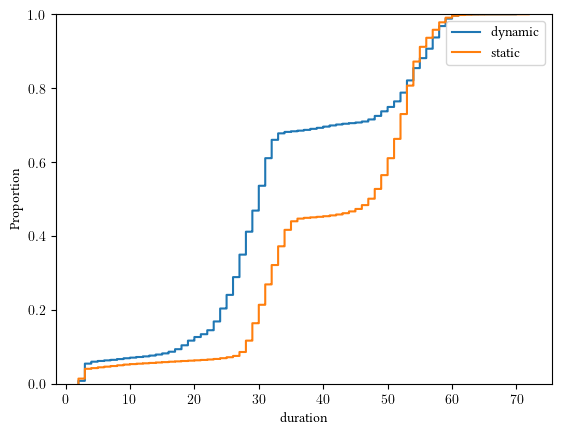

In [ ]:
dfd = data_invocations("dynamic")
dfd["duration"] = dfd["time_stop"] - dfd["time_start"]

dfs = data_invocations("static")
dfs["duration"] = dfs["time_stop"] - dfs["time_start"]

sns.ecdfplot(dfd["duration"], label="dynamic")
sns.ecdfplot(dfs["duration"], label="static")
plt.legend()
plt.show()

In [ ]:
df = pd.DataFrame(data={
    "time": data_dynamic["time"],
    "W_dynamic": data_dynamic["W"],
    "W_static": data_static["W"],
})
df["savings"] = 1-df["W_dynamic"]/df["W_static"]

In [ ]:
a, b = data_static["Wh"].max(), data_dynamic["Wh"].max()
(1-b/a)*100, a, b

(np.float64(7.8511877691722525),
 np.float64(1110.6165233077081),
 np.float64(1023.4199346673672))

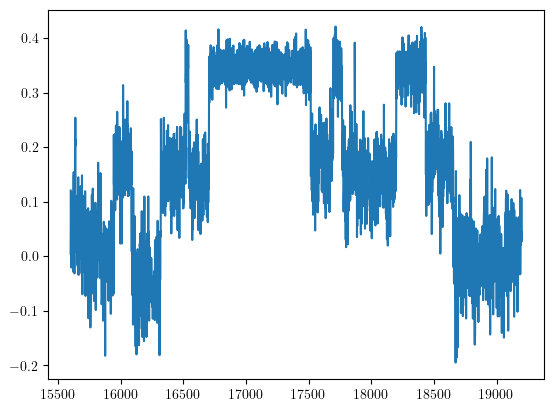

(np.float64(0.16818415211499751), np.float64(0.14653734339582758))

In [ ]:
df.head(n=10)

dff = df[df["time"] < (86_400/6/24*32)]
dff = dff[dff["time"] >= (86_400/6/24*26)]
len(dff), (32-26)*600

plt.plot(dff["time"], dff["savings"])
plt.show()

dff["savings"].mean(), dff["savings"].std()

In [ ]:
df["savings"].mean()

np.float64(0.08751615165700793)

In [ ]:
data_dynamic.head(n=10)

,time,W,J,Wh
0,0,5.93782,0.00000,0.00000
1,1,6.15616,6.04699,0.00168
2,2,6.02508,12.13761,0.00337
3,3,5.22179,17.76105,0.00493
4,4,4.94693,22.84541,0.00635
5,5,5.19156,27.91465,0.00775
6,6,5.10881,33.06484,0.00918
7,7,5.59514,38.41681,0.01067
8,8,5.21613,43.82245,0.01217
9,9,5.12296,48.99199,0.01361


#### Plot Leistung gesamte Cluster mit Clustergröße

In [ ]:
# neuer consumption/node count plot aber direkt 2 in 1

dfs = data_consumption(kind="static", melt=False, raw=True)
dfs["nodes_active"] = (dfs["W1"] != 0).astype(np.int64) + (dfs["W2"] != 0) + (dfs["W3"] != 0) + (dfs["W4"] != 0) + (dfs["W5"] != 0)
dfs["nodes_active_scaled"] = dfs["nodes_active"] * 5
dfs["W"] = dfs["W1"] + dfs["W2"] + dfs["W3"] + dfs["W4"] + dfs["W5"]
dfs["time"] = dfs["time"]-dfs["time"].min()

dfd = data_consumption(kind="dynamic", melt=False, raw=True)
dfd["nodes_active"] = (dfd["W1"] != 0).astype(np.int64) + (dfd["W2"] != 0) + (dfd["W3"] != 0) + (dfd["W4"] != 0) + (dfd["W5"] != 0)
dfd["nodes_active_scaled"] = dfd["nodes_active"] * 5
dfd["W"] = dfd["W1"] + dfd["W2"] + dfd["W3"] + dfd["W4"] + dfd["W5"]
dfd["time"] = dfd["time"]-dfd["time"].min()

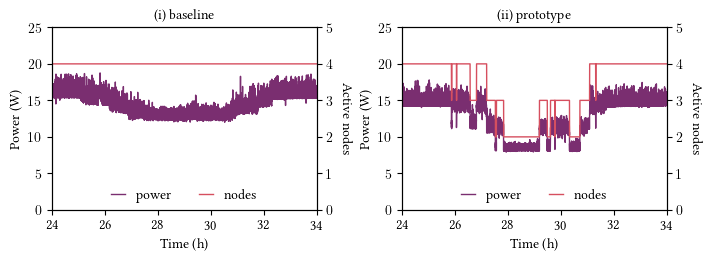

In [ ]:
def plot_power_subplots(dfs: pd.DataFrame, dfd: pd.DataFrame, colors: list, filename: str) -> None:

    # fig, (ax1a, ax2a) = plt.subplots(figsize=FIGSIZE_ACM_LARGE, ncols=2, nrows=1, constrained_layout=True)
    fig, (ax1a, ax2a) = plt.subplots(figsize=(7, 2.5), ncols=2, nrows=1, constrained_layout=True)

    sns.lineplot(x="time", y="W", data=dfs, ax=ax1a, linestyle="-", color=colors[0], label="power", linewidth=1)
    sns.lineplot(x="time", y="nodes_active_scaled", data=dfs, ax=ax1a, linestyle="-", color=colors[1], label="nodes", linewidth=1)

    sns.lineplot(x="time", y="W", data=dfd, ax=ax2a, linestyle="-", color=colors[0], label="power", linewidth=1)
    sns.lineplot(x="time", y="nodes_active_scaled", data=dfd, ax=ax2a, linestyle="-", color=colors[1], label="nodes", linewidth=1)

    ax1b = ax1a.twinx()
    ax2b = ax2a.twinx()

    ax1a.set_ylabel("Power (W)")
    ax2a.set_ylabel("Power (W)")
    ax1b.set_ylabel("Active nodes", rotation=270, rotation_mode=None, verticalalignment="center", horizontalalignment="left")
    ax2b.set_ylabel("Active nodes", rotation=270, rotation_mode=None, verticalalignment="center", horizontalalignment="left")

    ax1a.set_xlabel("Time (h)")
    ax2a.set_xlabel("Time (h)")

    ax1a.set_ylim(0, 25)
    ax2a.set_ylim(0, 25)
    ax1b.set_ylim(0, 5)
    ax2b.set_ylim(0, 5)

    ax1a.set_title("(i) baseline")
    ax2a.set_title("(ii) prototype")

    secs = lambda h: int(60*60*h/6)

    ll, ul = 24, 34
    xsteps = 5
    
    ax1a.set_xlim(secs(ll), secs(ul))
    ax2a.set_xlim(secs(ll), secs(ul))
    
    ax1a.set_xticks(
        ticks=range(secs(ll), secs(ul)+1, int((secs(ul)-secs(ll))//(xsteps))), 
        labels=range(ll, ul+1, int((ul-ll)//(xsteps)))
    )
    ax2a.set_xticks(
        ticks=range(secs(ll), secs(ul)+1, int((secs(ul)-secs(ll))//(xsteps))), 
        labels=range(ll, ul+1, int((ul-ll)//(xsteps)))
    )

    ax1a.legend(
        loc="lower center",
        ncols=2,
        frameon=False,
        fancybox=True,
        bbox_to_anchor=(0.5, -0.025),
        handlelength=1 
    )

    ax2a.legend(
        loc="lower center",
        ncols=2,
        frameon=False,
        fancybox=True,
        bbox_to_anchor=(0.5, -0.025),
        handlelength=1
    )

    # fig.subplots_adjust(wspace=0.4)

    fig.savefig(filename)
    plt.show()
    plt.close()


plot_power_subplots(dfs, dfd, colors, "../2025-paper-HaveYouTriedTurningItOff/graphs/subplots_power_draw.pdf")

#### Vergleich Energieverbrauch gesamte Cluster 

In [ ]:
data_dynamic = data_consumption("dynamic", False)
data_dynamic["J"] = integrate.cumulative_trapezoid(y=data_dynamic["W"], x=data_dynamic["time"], initial=0)
data_dynamic["Wh"] = data_dynamic["J"]/3_600

data_static = data_consumption("static", False)
data_static["J"] = integrate.cumulative_trapezoid(y=data_static["W"], x=data_static["time"], initial=0)
data_static["Wh"] = data_static["J"]/3_600

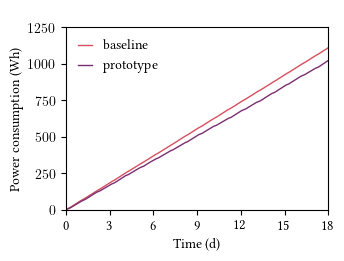

In [ ]:
def plot_consumption_cluster_total(data_static: pd.DataFrame, data_dynamic: pd.DataFrame, colors: list) -> None:

    fig, ax = plt.subplots(
        figsize=(3.33, 2.5), 
        constrained_layout=True
    )

    sns.lineplot(x="time", y="Wh", data=data_static, ax=ax, label="baseline", color=colors[1], linewidth=1)
    sns.lineplot(x="time", y="Wh", data=data_dynamic, ax=ax, label="prototype", color=colors[3], linewidth=1)

    ax.set_title(" ", color="white")

    xlim = 86_400 * 3
    ax.set_xlabel("Time (d)")
    ax.set_xlim(0, xlim)
    ax.set_xticks(
        ticks=range(0, xlim+1, xlim//6),
        labels=range(0, 18+1, 3)
    )

    ylim = 1250
    ax.set_ylabel("Power consumption (Wh)")
    ax.set_ylim(0, ylim)

    ax.grid(False)

    ax.legend(
        loc="upper left",
        frameon=False,
        markerfirst=True,
        handlelength=1
    )

    fig.savefig("../2025-paper-HaveYouTriedTurningItOff/graphs/consumption_cluster_total.pdf")
    plt.show()
    plt.close()

plot_consumption_cluster_total(data_static, data_dynamic, colors=colors)

#### Visualisierung Inputdaten

In [ ]:
def data_input(n_days: int) -> pd.DataFrame:
    data = []
    for i in range(n_days):
        data.append(pd.read_csv(f"./inputdata/requests_second/day_00{i}.csv"))
    df = pd.concat(data)
    df["total"] = df.loc[:, "0":"199"].astype(float).sum(axis=1)
    return df

df = data_input(7)

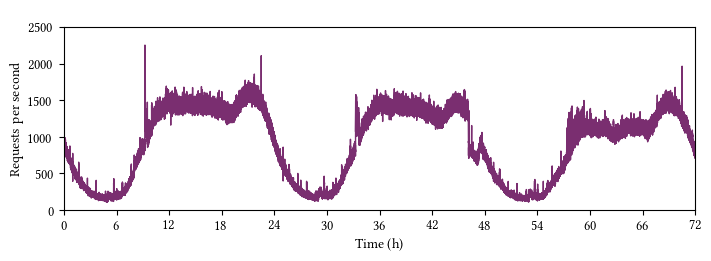

In [ ]:
def plot_input_requests_function(df: pd.DataFrame, function_id: int, colors: list, filename: str, smoothing: int = 1) -> None:

    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        # figsize=FIGSIZE_ACM_LARGE,
        figsize=(7, 2.5),
        constrained_layout=True
    )

    df = df.copy()
    df = df[df["time"] < 86_400*3]
    df[f"{function_id}"] = df[f"{function_id}"].rolling(window=smoothing, min_periods=1).mean()

    sns.lineplot(x="time", y=f"{function_id}", data=df, ax=ax, linewidth=1, color=colors[3])

    ax.set_title(" ") #for same height as other plots
    ax.set_ylabel("Requests per second")
    ax.set_xlabel("Time (h)")

    ax.set_ylim(0, 2500)
    ax.set_yticks(
        ticks=range(0, 2500+1, 500),
        labels=range(0, 2500+1, 500)
    )

    secs = lambda h: int(60*60*h)

    ll, ul = 0, 72
    xsteps = 12
    
    ax.set_xlim(secs(ll), secs(ul))
    ax.set_xticks(
        ticks=range(
            secs(ll),
            secs(ul)+1,
            int((secs(ul)-secs(ll))//xsteps)
        ),
        labels=range(
            ll,
            ul+1,
            int((ul-ll)//xsteps)
        )
    )

    plt.savefig(filename)
    plt.show()
    plt.close()


colors = sns.color_palette("flare", 4)
plot_input_requests_function(df, "28", colors, "../2025-paper-HaveYouTriedTurningItOff/graphs/input_function28.pdf", 3)

## Latenz-Analyse 

### Vier Dimensionen 

#### 1. Dimension: Stage 
S0, S1, S2, S3 …

#### 2. Dimension: Mode
concurrent / independent

#### 2. Dimension: Platform
ce / cr

#### 2. Dimension: Batching
batch / nobatch


### Cloud Run-CSV ist stufenunabhangig und muss aggregiert werden

--> pro Mode muss eine Cloud run Referenz Linie abgebildet werden

#### 1. CR-Phasenlatenzen Sum(S0(cr)+S1(cr)+S2(cr)+S3(cr)+S4(cr)) batch / concurrent 
S0 : for cr ist summe aus allen latencies_cr_batch deren eltern ordner und wieder eltern ordenr also sozusagen großeltenr ordner S0_concurrent enthält ... dh wir suchen aus S0_concurrent nach allen kindkind elementen die latencies_cr_batch in namen haben udn das selbe machen wir für die ganezn anderen stages 

hier haben wir 24 werte 
#### 2. CR-Phasenlatenzen Sum(S0(cr)+S1(cr)+S2(cr)+S3(cr)+S4(cr)) batch / independent

#### 3. CR-Phasenlatenzen Sum(S0(cr)+S1(cr)+S2(cr)+S3(cr)+S4(cr)) nobatch / concurrent 

#### 4. CR-Phasenlatenzen Sum(S0(cr)+S1(cr)+S2(cr)+S3(cr)+S4(cr)) nobatch / independent




In [40]:
import json
import re
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Iterable

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display


In [111]:

TESTRESULTS_ROOT = Path("/Users/susannahufnagl/Desktop/UNI_Bachelor/TU Berlin/lebach/ba/Testresults") # so lange ich aus lokal arbeite
METRIC_COL = ["client_total_ms", "server_latency_ms"]
METRIC_CLIENT = "client_total_ms"
METRIC_SERVER = "server_latency_ms"
METRICS = [METRIC_CLIENT, METRIC_SERVER]


STAGES = ["S0", "S1", "S2", "S3", "S4"]
MODES = ["concurrent", "independent"]
BATCHINGS = ["batch", "nobatch"]



def parse_metadata(csv_path: Path):
    
    # csv_path Beispiel:
    # Testresults/S0_concurrent/2025-11-06_17-19-50_run-6136/latencies_cr_batch_*.csv
    

    #S0_concurrent
    stage_mode = csv_path.parents[1].name ## --> ein ordner über eltern ordenr 
    stage, mode = stage_mode.split("_")

    #plattform + batching aus Dateiname nehmen
    m = re.match(r"latencies_(ce|cr)_(batch|nobatch)_", csv_path.name)
    if not m:
        raise ValueError(f"Konnte Dateinamen nicht lesen: {csv_path.name}")

    platform = m.group(1)
    batching = m.group(2)

    #run-Ordner
    run_id = csv_path.parents[0].name  #z.B.2025-11-06_17-19-50_run-6136 --> evtl ohne eckige klammer part 

    return stage, mode, platform, batching, run_id


def load_latencies(root: Path = TESTRESULTS_ROOT):
    rows = []
    for csv in root.rglob("latencies_*.csv"):
        stage, mode, platform, batching, run_id = parse_metadata(csv)
        df = pd.read_csv(csv)

        df["stage"] = stage
        df["mode"] = mode
        df["platform"] = platform
        df["batching"] = batching
        df["run"] = run_id
        df["source_file"] = csv

        rows.append(df)

    return pd.concat(rows, ignore_index=True)


lat = load_latencies()
print("CSV-Daten geladen:", lat.shape)
lat.head()










CSV-Daten geladen: (92000, 13)


,ts_iso,endpoint,http_status,client_total_ms,server_latency_ms,url,cold_start,stage,mode,platform,batching,run,source_file
0,2025-11-15T12:41:37Z,cr_nobatch,200,107.857,6.896,https://cloudrun-broker-single-go-997595983891...,NaN,S3,independent,cr,nobatch,2025-11-15_12-41-35_run-6785,/Users/susannahufnagl/Desktop/UNI_Bachelor/TU ...
1,2025-11-15T12:41:37Z,cr_nobatch,200,102.444,6.927,https://cloudrun-broker-single-go-997595983891...,NaN,S3,independent,cr,nobatch,2025-11-15_12-41-35_run-6785,/Users/susannahufnagl/Desktop/UNI_Bachelor/TU ...
2,2025-11-15T12:41:37Z,cr_nobatch,200,110.376,7.383,https://cloudrun-broker-single-go-997595983891...,NaN,S3,independent,cr,nobatch,2025-11-15_12-41-35_run-6785,/Users/susannahufnagl/Desktop/UNI_Bachelor/TU ...
3,2025-11-15T12:41:38Z,cr_nobatch,200,90.419,8.128,https://cloudrun-broker-single-go-997595983891...,NaN,S3,independent,cr,nobatch,2025-11-15_12-41-35_run-6785,/Users/susannahufnagl/Desktop/UNI_Bachelor/TU ...
4,2025-11-15T12:41:38Z,cr_nobatch,200,81.711,7.768,https://cloudrun-broker-single-go-997595983891...,NaN,S3,independent,cr,nobatch,2025-11-15_12-41-35_run-6785,/Users/susannahufnagl/Desktop/UNI_Bachelor/TU ...


## Cloud Run Aggregation
--> brauch ich nicht weil stageless, stattdessen über mode und batchin kombination gruppieren


In [ ]:





def compute_cr_ref(lat, metric: str):
    return (
        lat[lat["platform"] == "cr"]
        .groupby(["mode", "batching"])[metric]
        .agg(["mean", "std", "count"])
        .reset_index()
    )


cr_ref_client = compute_cr_ref(lat, METRIC_CLIENT)
cr_ref_server = compute_cr_ref(lat, METRIC_SERVER)



## Compute Engine Aggregation


In [125]:
def aggregate_ce_by_stage(lat, metric_col: str):
 
   ##ce daten raus filtern 

    ce = lat[lat["platform"] == "ce"].copy()

    #gruppieren pro run für später Tageszeiten abhängige messungen
    per_run = (
        ce.groupby(["stage", "mode", "batching", "run"])[metric_col]
        .agg(["mean", "median", "std", "count"])
        .reset_index()
        .sort_values(["stage", "run"])
    )

    #gruppierung pro stache 
    per_stage = (
        ce.groupby(["stage", "mode", "batching"])[metric_col]
        .agg(["mean", "median", "std", "count"])
        .reset_index()
        .sort_values(["mode", "batching", "stage"])
    )
    # groups = ce.groupby(["stage", "mode", "batching"])
    # list(groups.groups.keys())[:20] 
    return per_run, per_stage
ce = lat[lat["platform"] == "ce"].copy()

groups = ce.groupby(["stage", "mode", "batching"])
list(groups.groups.keys())[:20]
# Client-Latenz
ce_run_stats_client, ce_stage_stats_client = aggregate_ce_by_stage(lat, metric_col="client_total_ms")

# # Server-Latenz
ce_run_stats_server, ce_stage_stats_server = aggregate_ce_by_stage(lat, metric_col="server_latency_ms")
ce_run_stats_server




,stage,mode,batching,run,mean,median,std,count
0,S0,concurrent,batch,2025-11-06_17-19-50_run-6136,12.211052,12.0390,0.978283,500
4,S0,concurrent,nobatch,2025-11-06_17-19-50_run-6136,6.753998,6.5940,0.930774,500
8,S0,independent,batch,2025-11-06_17-25-44_run-8284,12.003884,11.7665,1.044596,500
12,S0,independent,nobatch,2025-11-06_17-25-44_run-8284,6.652556,6.4585,0.924223,500
1,S0,concurrent,batch,2025-11-14_21-17-29_run-2627,12.227654,12.0090,1.279348,500
...,...,...,...,...,...,...,...,...
90,S4,independent,nobatch,2025-11-15_14-53-15_run-7276,8.093080,7.2390,2.400309,500
79,S4,concurrent,batch,2025-11-18_07-44-29_run-9460,14.367180,13.1990,3.424202,500
83,S4,concurrent,nobatch,2025-11-18_07-44-29_run-9460,7.962768,7.2845,2.167374,500
87,S4,independent,batch,2025-11-18_07-48-45_run-0557,14.317792,13.2155,3.026191,500


In [120]:
ce_run_stats_client, ce_stage_stats_client = aggregate_ce_by_stage(lat, metric_col="client_total_ms")
ce_run_stats_client

# ce_run_stats_client--> statisik pro run
# ce_stage_stats_client --> statistik pro stage


,stage,mode,batching,run,mean,median,std,count
0,S0,concurrent,batch,2025-11-06_17-19-50_run-6136,14.100468,13.5630,2.023076,500
4,S0,concurrent,nobatch,2025-11-06_17-19-50_run-6136,9.240072,8.5865,2.107246,500
8,S0,independent,batch,2025-11-06_17-25-44_run-8284,13.830312,13.3335,1.900173,500
12,S0,independent,nobatch,2025-11-06_17-25-44_run-8284,8.501896,7.9340,1.782181,500
1,S0,concurrent,batch,2025-11-14_21-17-29_run-2627,13.378216,12.9455,1.720968,500
...,...,...,...,...,...,...,...,...
90,S4,independent,nobatch,2025-11-15_14-53-15_run-7276,16.141744,14.3810,4.753454,500
79,S4,concurrent,batch,2025-11-18_07-44-29_run-9460,22.767120,21.3945,5.158579,500
83,S4,concurrent,nobatch,2025-11-18_07-44-29_run-9460,16.411732,15.1730,4.277153,500
87,S4,independent,batch,2025-11-18_07-48-45_run-0557,22.625468,21.0020,5.237435,500


## ReferenzLinie für Cloud Run


In [126]:


def compute_cr_reference(lat, metric_col):
   

    # pro (mode, batching) der globale Durchschnitt über alle CR-Messungen
   
    cr = lat[lat["platform"] == "cr"].copy()

    agg = (
        cr.groupby(["mode", "batching"])[metric_col]
          .agg(["mean", "median", "std", "count"])
          .reset_index()
          .sort_values(["mode", "batching"])
    )

    return agg

cr_ref_server = compute_cr_reference(lat, metric_col="server_latency_ms")
cr_ref_client = compute_cr_reference(lat, metric_col="client_total_ms")





In [127]:
## tabelle fpr plots, nimmt cr_ref ergebnise und such genau den Wert den ich für die bestimmte referenzline brauche 

def get_cr_ref(cr_ref_table, mode, batching, kind="mean"):
    row = cr_ref_table[ # --> die vier kombinationen 
        (cr_ref_table["mode"] == mode) &
        (cr_ref_table["batching"] == batching)
    ]
    if row.empty:
        raise ValueError(f"fehler {mode}/{batching}")
    return float(row.iloc[0][kind])

get_cr_ref(cr_ref_server, "concurrent", "batch") # z.B



13.146478260869566

## Ce- kumulativ Latenz für Stages 

Pro Kombination benötge ich (mode,batching)



1. CE_mean_S0

2. CE_mean_S1

3. CE_mean_S2

4. CE_mean_S3

5. CE_mean_S4 (Gesamtlatenz)

--> daraus berechne ich die Phasen Anteile:

z.B anteil_Sx = CE_mean_Sx / CE_mean_S4

--> phasen Vergrößerung

z.B delta_Sx = CE_mean_Sx - CE_mean_S(x-1)

--> relative Steigerung 

delta_rel_Sx = delta_Sx / CE_mean_S4 * 100




In [145]:
import numpy as np  # falls noch nicht oben importiert

def compute_ce_phase_metrics(ce_stage_stats, stages=STAGES):
    rows = []

    for mode in MODES:
        for batching in BATCHINGS:
            subset = ce_stage_stats[
                (ce_stage_stats["mode"] == mode) &
                (ce_stage_stats["batching"] == batching) &
                (ce_stage_stats["stage"].isin(stages))
            ].copy()

            if subset.empty:
                continue

            # sortieren nach Stage-Nummer (S0..S4)
            subset["stage_num"] = subset["stage"].str.extract(r"S(\d+)").astype(int)
            subset = subset.sort_values("stage_num")

            stage_list = list(subset["stage"])
            means = list(subset["mean"])

            base = means[0]          # S0=Basisarchitektur
            ce_total = means[-1]     # S4=vollständige Architektur
            incr_total = ce_total - base  #zusätzlicher Overhead

            # Inkremente von Phase zu Phase: S0->S1, S1->S2 etc 
            increments = [0.0]
            for i in range(1, len(means)):
                increments.append(means[i] - means[i - 1])

            # Anteile jeder Stufe am zusätzlichen Overhead (S4-S0)
            if incr_total > 0:
                parts = [inc / incr_total for inc in increments]
                delta_rel = [s * 100 for s in parts]  
            else:
                parts = [np.nan] * len(increments)
                delta_rel = [np.nan] * len(increments)

            rows.append({
                "mode": mode,
                "batching": batching,
                "stages": stage_list,
                "ce_means": means,
                "ce_base": base,
                "ce_total": ce_total,
                "ce_increment_total": incr_total,
                "phase_increments": increments,          # S_i - S_{i-1}
                "phase_parts": parts,         # Anteil am Overhead
                "phase_parts_percent": delta_rel,
            })

    return rows

ce_phase_metrics_client = compute_ce_phase_metrics(ce_stage_stats_client)
ce_phase_metrics_server = compute_ce_phase_metrics(ce_stage_stats_server)



## Plots 

### 1. Boxplot pro Phase (CE vs CR.Referenz)

für jede Kombination aus (batch/nobatch x concurrent/independent)

--> Boxplots für S0-5
--> horizontale Linie für CR-Referenz, die bleibt aber konstant weil keine Phasen


### 2. Linienplot der CE-Mittelwerte pro Phase

--> CE_mean_S0 --> CE_mean_S1 --> CE_mean_S2 --> CE_mean_S3 --> CE_mean_S4
--> CR-Referenz-Linie dazu

zeigt, ob

1. CE sich der CR-Linie annähert

2. CE schneller wächst

3. welchen Effekt batching/Mode hat


### 3. Anteil aller Phasen an S4

1.  welche Phase die größte Last verursacht

2. welche Phase optimiert werden sollte

3. ob batching/concurrent überhaupt wirkt


### 4. Verteilungsdesigner Boxplots nach Plattform 

CE vs. CR (z. B. beide Boxplots nebeneinander)
-->  zeigt Varianz, Ausreißer


### 5. Heatmap: relative Phase Importance

x-Achse = stages
y-Achse = mode/batching
Zelle = % Anteil an S4



### 1. Plot: Boxplot pro Phase (CE)+ Cr Referenz Linie 

In [157]:
def plot_boxplots_ce_per_phase_with_cr_ref(lat, cr_refs, mode, batching, metric_col):
    
    # für eine Kombination (mode,batching):
    # Boxplots der CE-Latenzen pro Stage
    # CR-Referenzlinie
 
    print("Mode:", mode)
    print("Batching:", batching)
    print("Metric:", metric_col)
    subset_ce = lat[ # filter der daten aus der kombination
        (lat["platform"] == "ce") &
        (lat["mode"] == mode) &
        (lat["batching"] == batching) &
        (lat["stage"].isin(STAGES))
    ].copy()

    if subset_ce.empty:
        print(f"Keine CE-Daten für {mode}/{batching}")
        return

    #daten je Stage
    data = []
    stage_labels = []

    for stage in STAGES:
        s = subset_ce[subset_ce["stage"] == stage][metric_col]
        if s.empty:
            continue
        data.append(s.values)
        stage_labels.append(stage)

    cr_ref = get_cr_ref(cr_refs, mode, batching)
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=stage_labels, showfliers=True)
    plt.axhline(cr_ref, linestyle="--", label=f"CR Referenz {cr_ref:.2f} ms")

    
    
    # plt.axhline(cr_ref, linestyle="--", label=f"CR Referenz (mean sum) {cr_ref:.2f} ms")

    plt.title(f"Compute Engine Boxplots pro Stage mit CR-Referenz\nMode={mode}, Batching={batching}")
    plt.xlabel("Stage")
    plt.ylabel(f"Latenz ({metric_col})")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.show()

# holt alle ce Latenzen und baut für jede stage boxlot, und nimmt gleiche cloud run kombi Referenz 








Bsp plot_boxplots_ce_per_phase_with_cr_ref(lat, cr_refs, mode="concurrent", batching="batch")


Mode: concurrent
Batching: nobatch
Metric: server_latency_ms


/var/folders/w_/y3xgslr95k5ddtwddqby08wc0000gn/T/ipykernel_3839/1144919549.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stage_labels, showfliers=True)


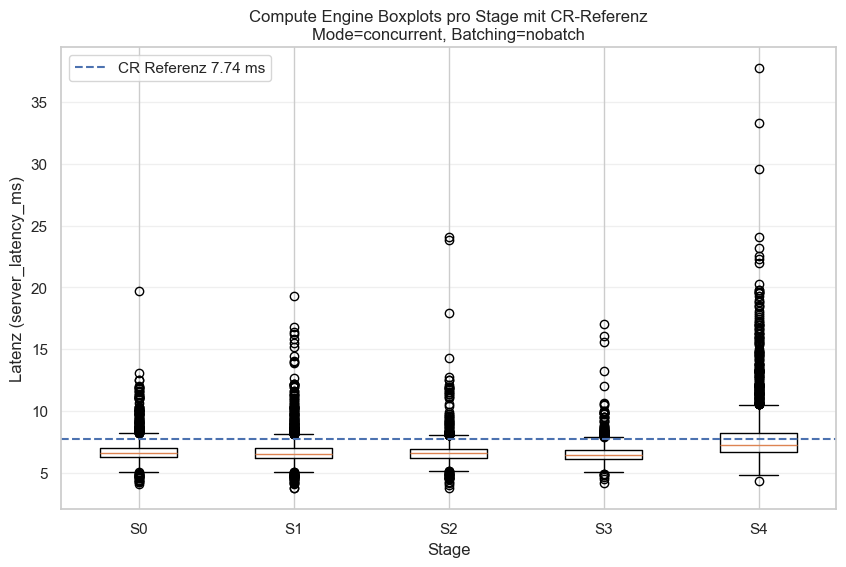

Mode: concurrent
Batching: batch
Metric: server_latency_ms


/var/folders/w_/y3xgslr95k5ddtwddqby08wc0000gn/T/ipykernel_3839/1144919549.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stage_labels, showfliers=True)


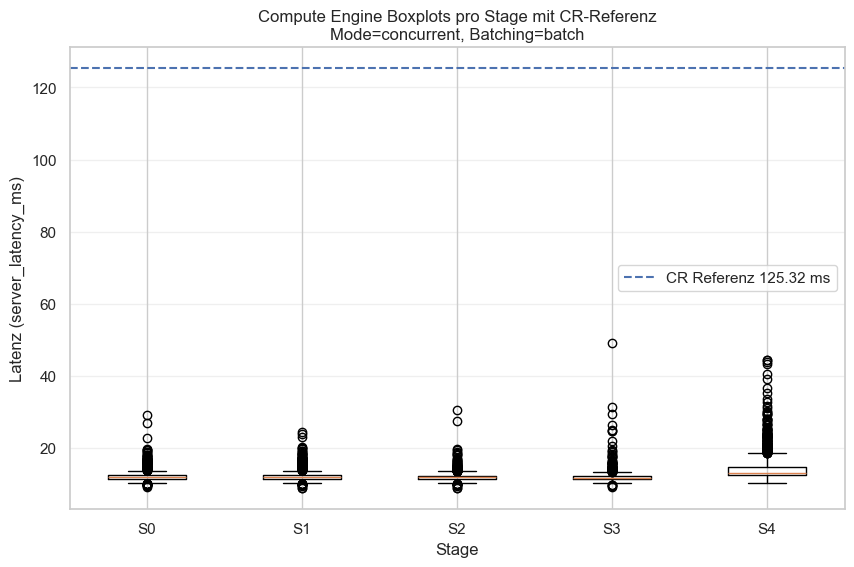

Mode: independent
Batching: nobatch
Metric: server_latency_ms


/var/folders/w_/y3xgslr95k5ddtwddqby08wc0000gn/T/ipykernel_3839/1144919549.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stage_labels, showfliers=True)


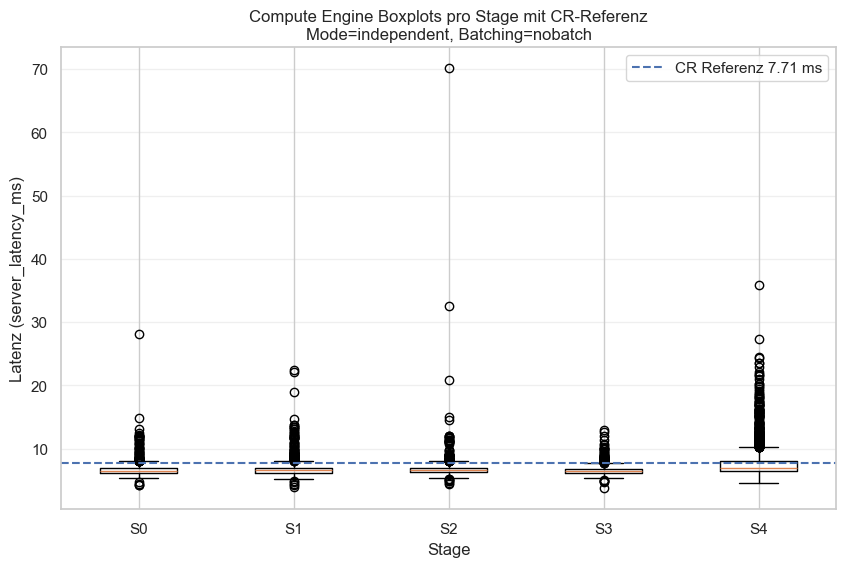

Mode: independent
Batching: batch
Metric: server_latency_ms


/var/folders/w_/y3xgslr95k5ddtwddqby08wc0000gn/T/ipykernel_3839/1144919549.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stage_labels, showfliers=True)


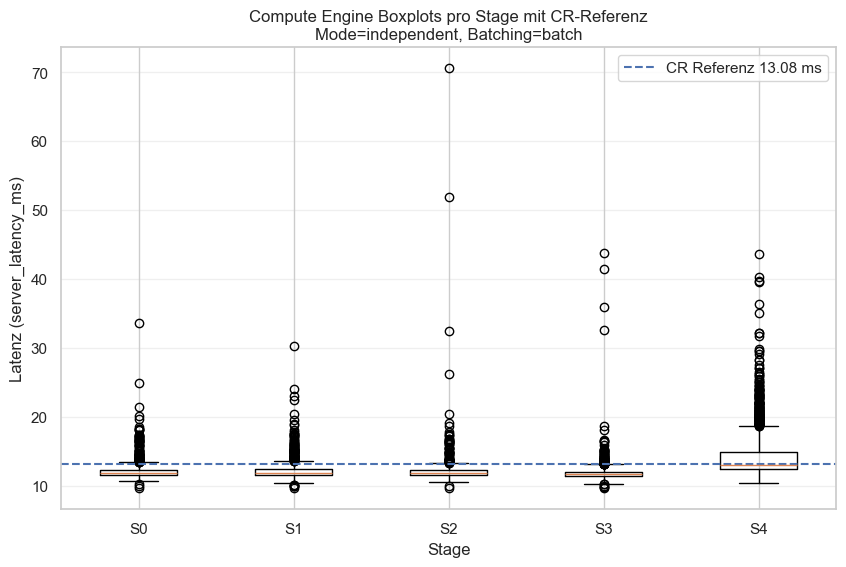

Mode: independent
Batching: batch
Metric: client_total_ms


/var/folders/w_/y3xgslr95k5ddtwddqby08wc0000gn/T/ipykernel_3839/1144919549.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stage_labels, showfliers=True)


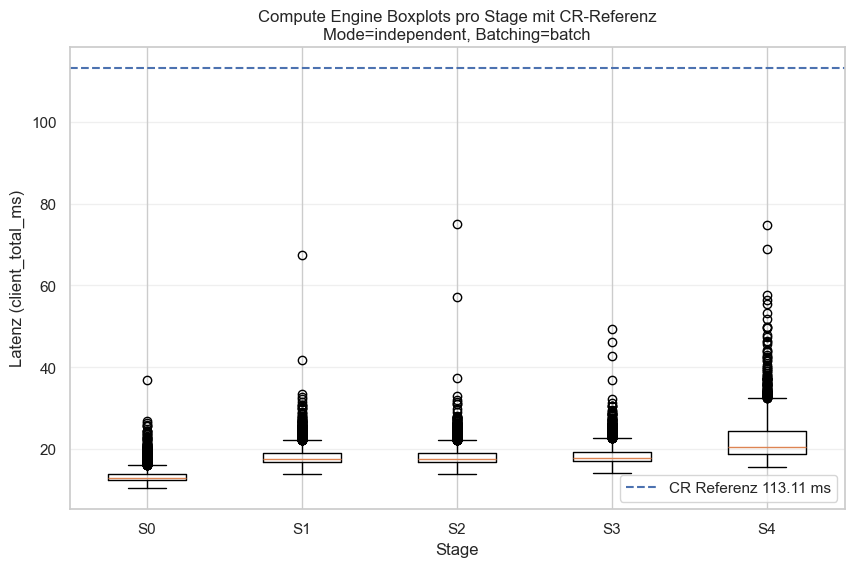

Mode: independent
Batching: nobatch
Metric: client_total_ms


/var/folders/w_/y3xgslr95k5ddtwddqby08wc0000gn/T/ipykernel_3839/1144919549.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stage_labels, showfliers=True)


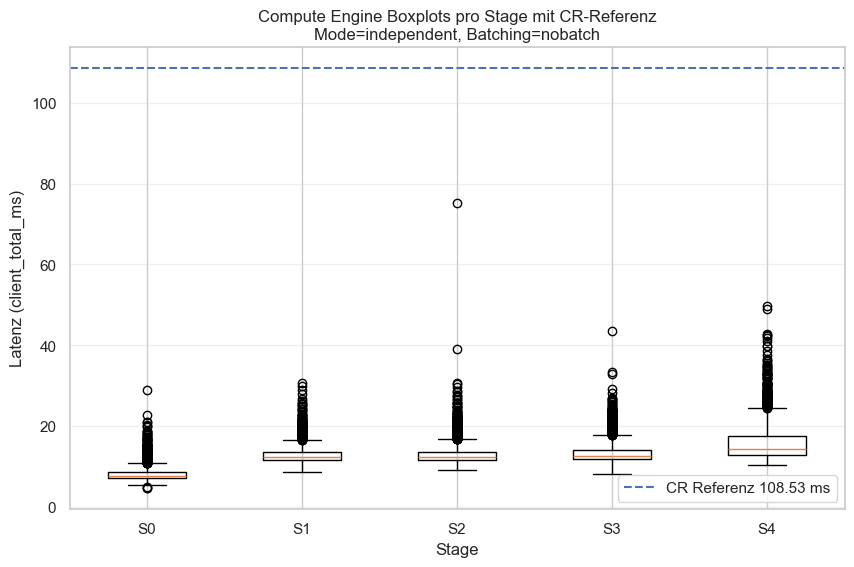

Mode: concurrent
Batching: batch
Metric: client_total_ms


/var/folders/w_/y3xgslr95k5ddtwddqby08wc0000gn/T/ipykernel_3839/1144919549.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stage_labels, showfliers=True)


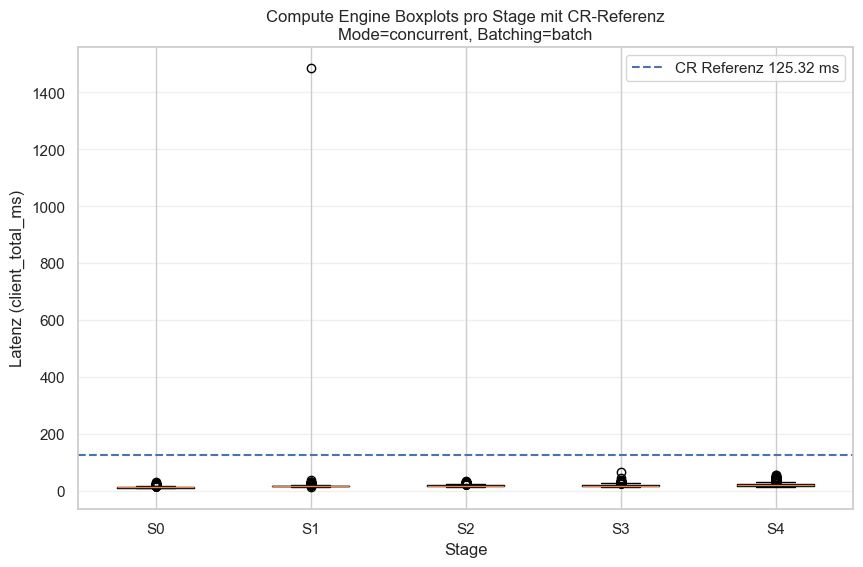

Mode: concurrent
Batching: nobatch
Metric: client_total_ms


/var/folders/w_/y3xgslr95k5ddtwddqby08wc0000gn/T/ipykernel_3839/1144919549.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=stage_labels, showfliers=True)


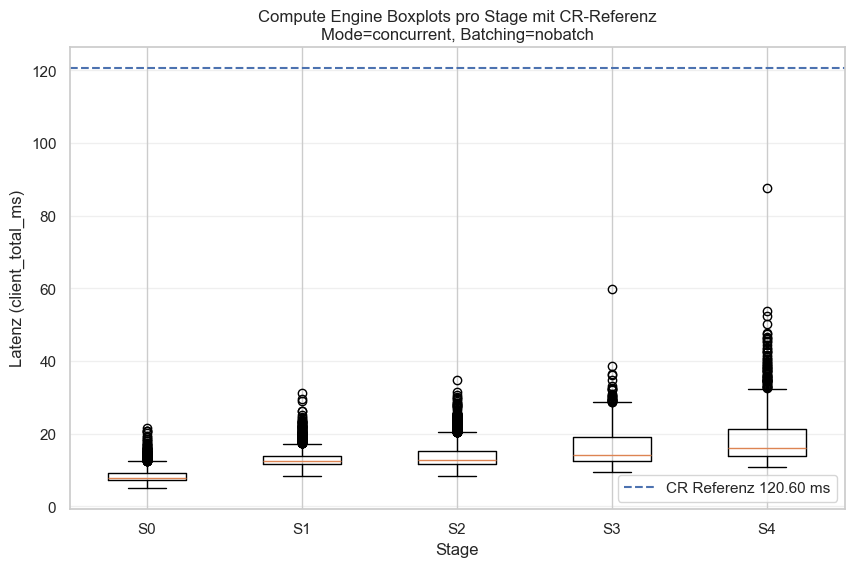

In [158]:
plot_boxplots_ce_per_phase_with_cr_ref(
    lat,
    cr_ref_server,   # ← das sind Client-Referenzen
    mode="concurrent",
    batching="nobatch",
    metric_col="server_latency_ms"
)
plot_boxplots_ce_per_phase_with_cr_ref(
    lat, cr_ref_client, "concurrent", "batch", metric_col="server_latency_ms"
)

plot_boxplots_ce_per_phase_with_cr_ref(
    lat,
    cr_ref_server,   # ← das sind Client-Referenzen
    mode="independent",
    batching="nobatch",
    metric_col="server_latency_ms"
)
plot_boxplots_ce_per_phase_with_cr_ref(
    lat, cr_ref_server, "independent", "batch", metric_col="server_latency_ms"
)
plot_boxplots_ce_per_phase_with_cr_ref(
    lat, cr_ref_client, "independent", "batch", metric_col="client_total_ms"
)
plot_boxplots_ce_per_phase_with_cr_ref(
    lat, cr_ref_client, "independent", "nobatch", metric_col="client_total_ms"
)
plot_boxplots_ce_per_phase_with_cr_ref(
    lat, cr_ref_client, "concurrent", "batch", metric_col="client_total_ms"
)
plot_boxplots_ce_per_phase_with_cr_ref(
    lat, cr_ref_client, "concurrent", "nobatch", metric_col="client_total_ms"
)


### Plot 2: Linienplot CE-Mittelwerte pro Phase + CR Referenz Linie 

In [139]:
def plot_ce_means_per_phase_with_cr_ref(ce_phase_metrics, cr_refs, mode, batching, metric_label):
    

    entry = next(
        (e for e in ce_phase_metrics if e["mode"] == mode and e["batching"] == batching), # ist die liste compute_ce_phase_metrics
        None,
    )
    if entry is None:
        print(f"Keine CE für {mode}/{batching}")
        return

    stages = entry["stages"]
    means = entry["ce_means"]

    # cr_refs muss hier compute_cr_reference sein (cr_ref_client oder cr_ref_server)
    cr_ref = get_cr_ref(cr_refs, mode, batching, kind="mean")

    plt.figure(figsize=(10, 6))
    line=plt.plot(stages, means, marker="o", label="CE mean per Stage")
    for i, m in enumerate(means):
        plt.text(
            i,                # x-Position
            m,               
            f"{m:.2f}",       
            ha="center",
            va="bottom",
            fontsize=9,
        )


    # ichtig: keine „mean sum“ mehr –es ist einfach der globale CR-Mean
    plt.axhline(cr_ref, linestyle="--", label=f"CR Referenz {cr_ref:.2f} ms")

    plt.title(f"CE-Mittelwerte pro Stage mit Cloud-Run-Referenz\nMode={mode}, Batching={batching}")
    plt.xlabel("Stage")
    plt.ylabel(metric_label)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    


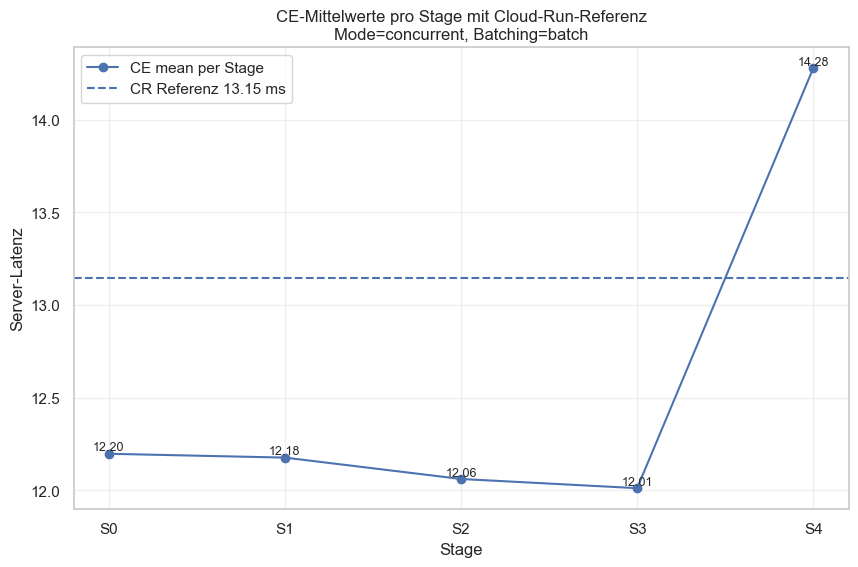

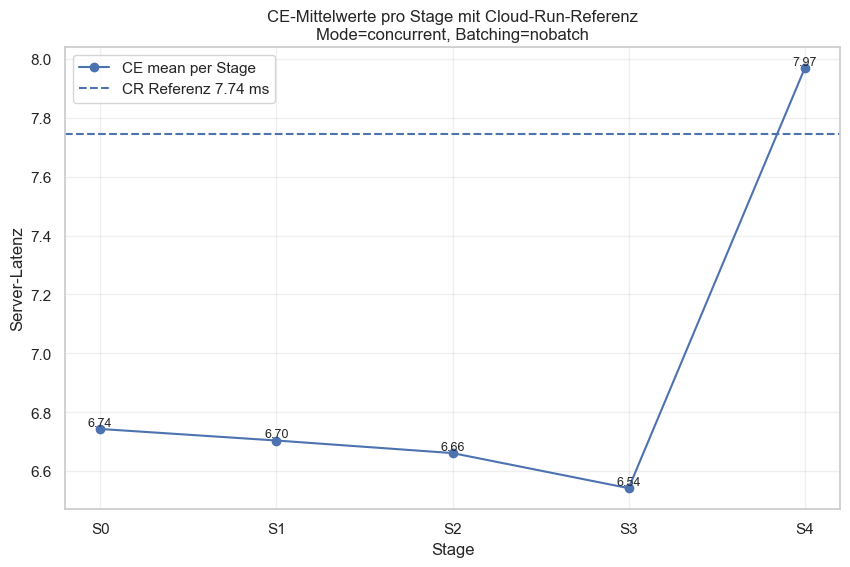

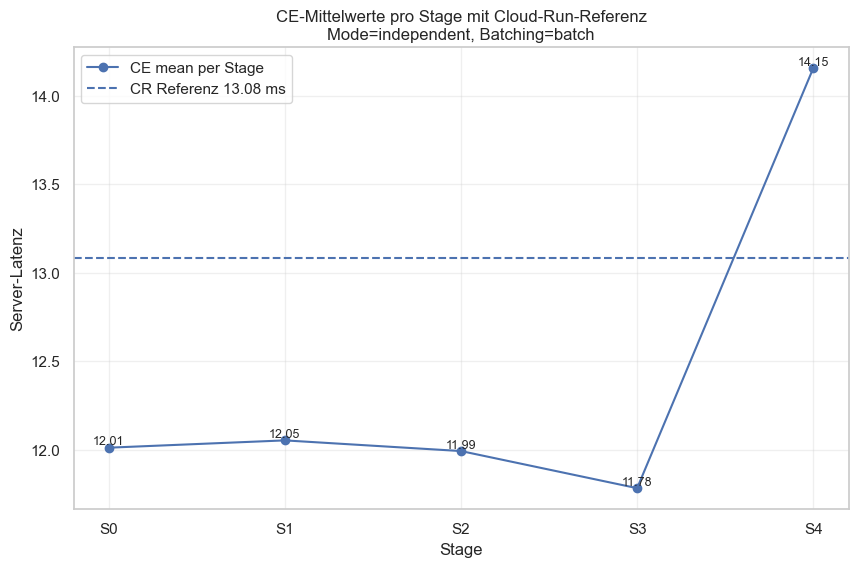

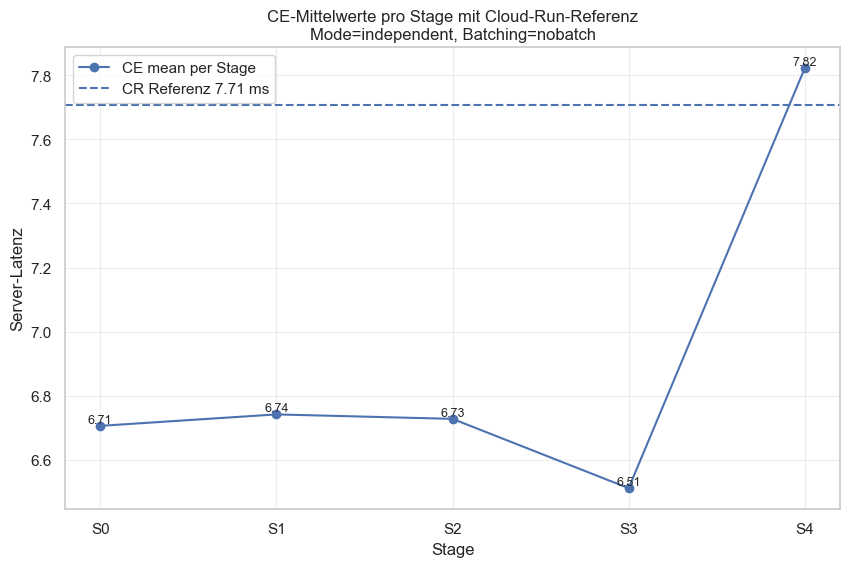

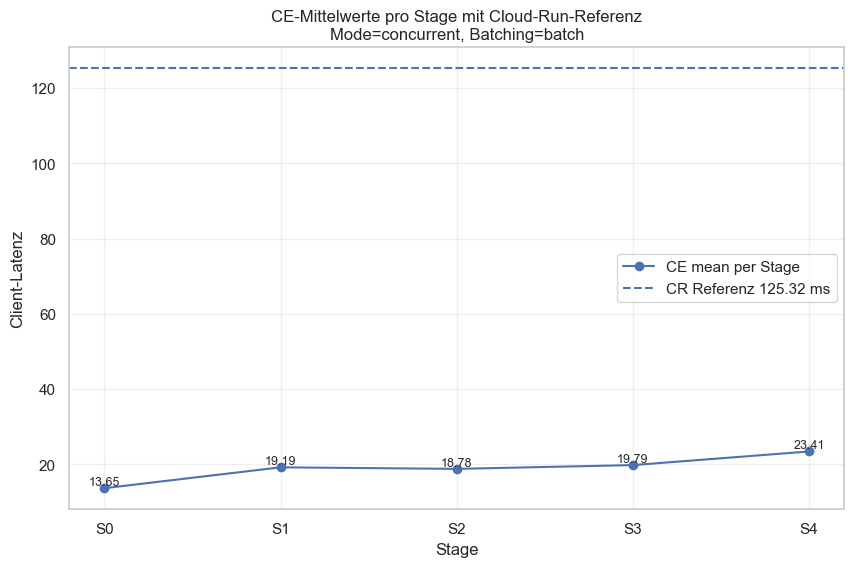

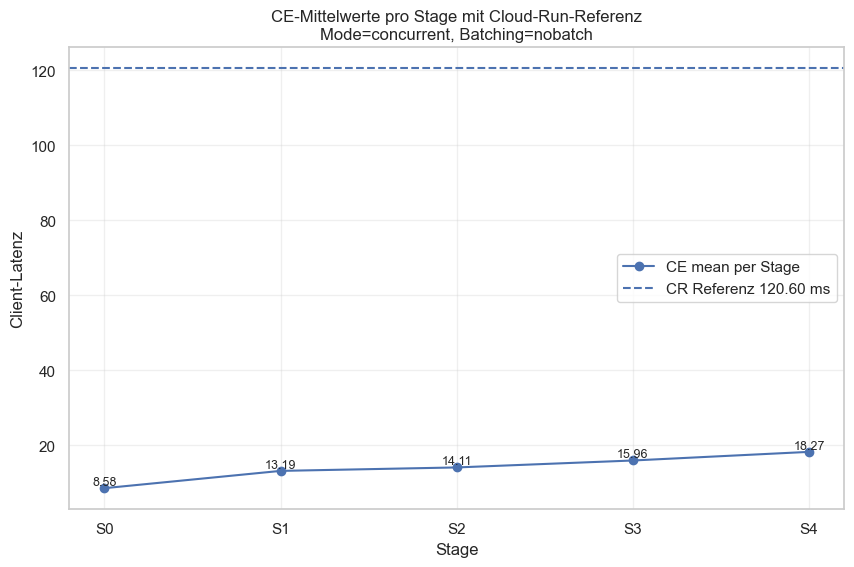

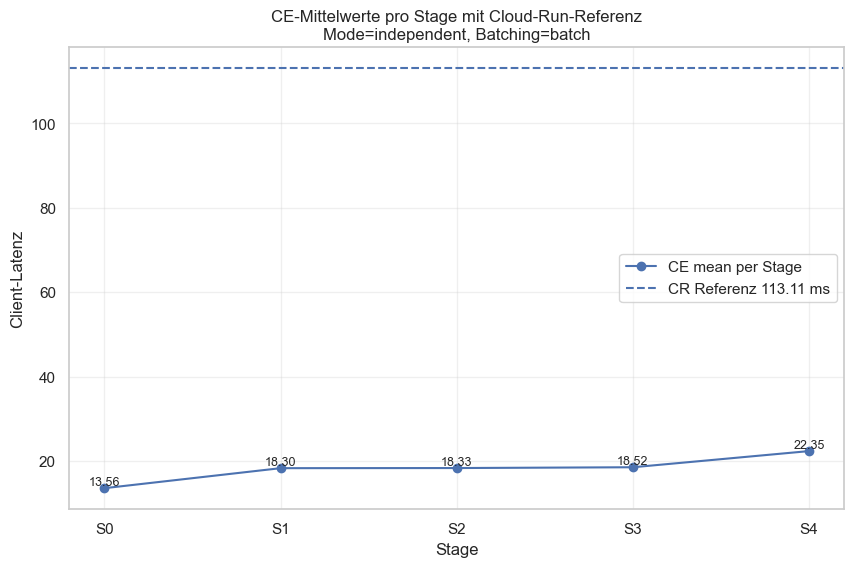

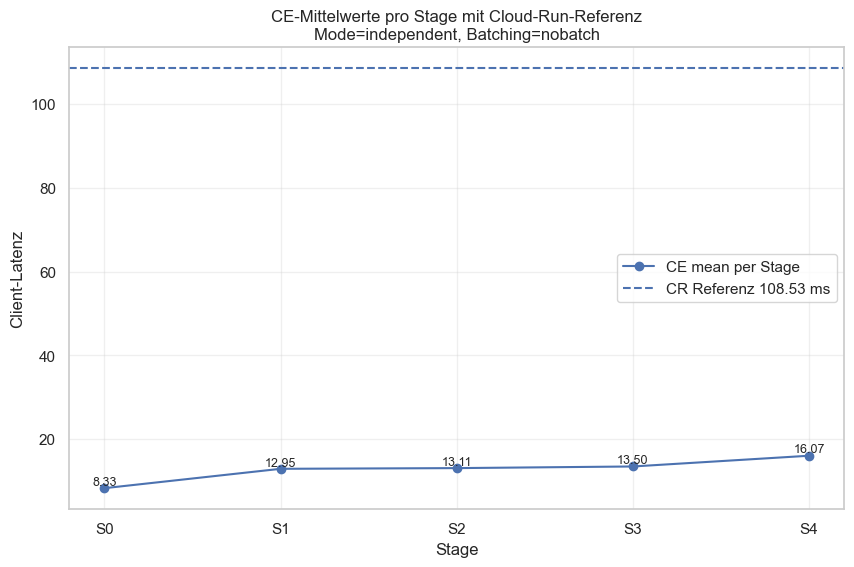

In [146]:
plot_ce_means_per_phase_with_cr_ref(
    ce_phase_metrics_server,
    cr_ref_server,   # sind server Referenzen
    mode="concurrent",
    batching="batch",
    metric_label="Server-Latenz",
)
plot_ce_means_per_phase_with_cr_ref(
    ce_phase_metrics_server,
    cr_ref_server,   # sind server Referenzen
    mode="concurrent",
    batching="nobatch",
    metric_label="Server-Latenz",
)
plot_ce_means_per_phase_with_cr_ref(
    ce_phase_metrics_server,
    cr_ref_server,   # sind server Referenzen
    mode="independent",
    batching="batch",
    metric_label="Server-Latenz",
)
plot_ce_means_per_phase_with_cr_ref(
    ce_phase_metrics_server,
    cr_ref_server,   # sind server Referenzen
    mode="independent",
    batching="nobatch",
    metric_label="Server-Latenz",
)

plot_ce_means_per_phase_with_cr_ref(
    ce_phase_metrics_client,
    cr_ref_client,   
    mode="concurrent",
    batching="batch",
    metric_label="Client-Latenz",
)
plot_ce_means_per_phase_with_cr_ref(
    ce_phase_metrics_client,
    cr_ref_client,  
    mode="concurrent",
    batching="nobatch",
    metric_label="Client-Latenz",
)
plot_ce_means_per_phase_with_cr_ref(
    ce_phase_metrics_client,
    cr_ref_client,   
    mode="independent",
    batching="batch",
    metric_label="Client-Latenz",
)
plot_ce_means_per_phase_with_cr_ref(
    ce_phase_metrics_client,
    cr_ref_client,   
    mode="independent",
    batching="nobatch",
    metric_label="Client-Latenz",
)





### Plot 3: Anteil aller Phase an S4

In [159]:
def plot_phase_part(ce_phase_metrics):
    combos = []
    all_parts = []

    for entry in ce_phase_metrics:
        label = f"{entry['mode']}\n{entry['batching']}"
        combos.append(label)

        parts = entry["phase_parts"]   # muss in compute_ce_phase_metrics gesetzt sein
        if len(parts) < len(STAGES):
            parts = parts + [0.0] * (len(STAGES) - len(parts))
        all_parts.append(parts)

    all_parts = np.array(all_parts)  # (num_combos, num_stages)
    x = np.arange(len(combos))

    plt.figure(figsize=(14, 6))

    width = 0.15
    offsets = np.linspace(-0.3, 0.3, len(STAGES))

    for i, stage in enumerate(STAGES):
        yvals = all_parts[:, i] * 100  # Prozent

        # Balken
        plt.bar(
            x + offsets[i],
            yvals,
            width=width,
            label=stage,
        )

        # Labels
        for xi, yi in zip(x + offsets[i], yvals):
            if np.isnan(yi):
                continue
            # kleiner Offset in Daten-Einheiten
            dy = 2 if yi >= 0 else -2
            va = "bottom" if yi >= 0 else "top"

            plt.text(
                xi,
                yi + dy,
                f"{yi:.1f}%",   # z.B. -12.5%
                ha="center",
                va=va,
                fontsize=8,
            )

    plt.axhline(0, color="black", linewidth=1)
    plt.xticks(x, combos)
    plt.ylabel("Anteil am Overhead (S4 − S0) in %")
    plt.title("Anteil der Stufen am zusätzlichen Overhead (positiv/negativ) je Mode/Batching")
    plt.legend(title="Stage", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()



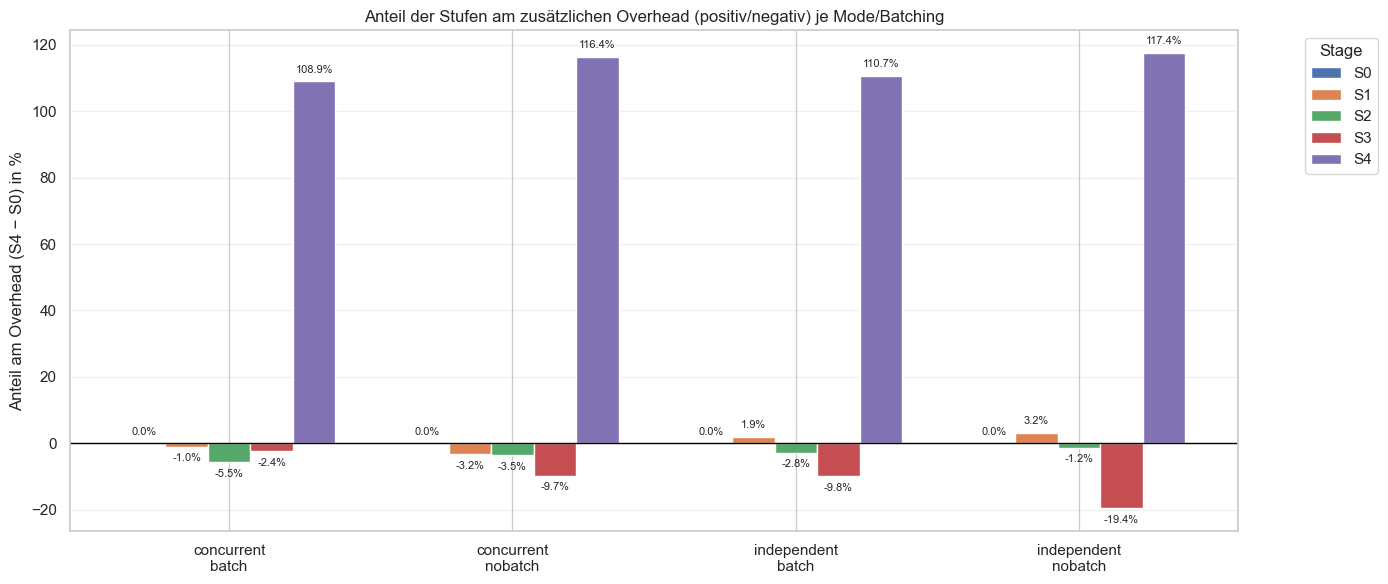

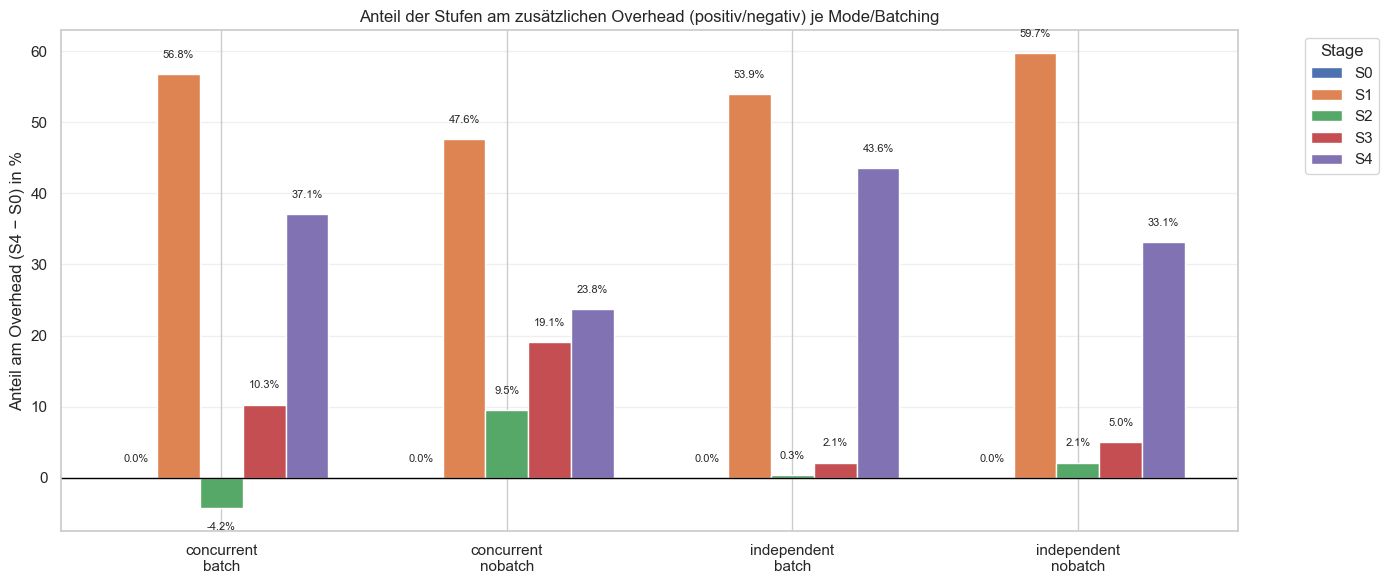

In [154]:
plot_phase_part(ce_phase_metrics_server)

plot_phase_part(ce_phase_metrics_client)


### Plot 4  Verteilung boxplot nach Plattformen

In [ ]:
def plot_distribution_boxplots_ce_vs_cr(lat, mode, batching, metric_col=METRIC_COL):
    
    #CE vs CR Boxplots pro Stage nebeneinander.
    # Zeigt Varianz/Verteilung je Plattform.
 
    subset = lat[
        (lat["mode"] == mode) &
        (lat["batching"] == batching) &
        (lat["stage"].isin(STAGES))
    ].copy()

    if subset.empty:
        print(f"Keine Daten für {mode}/{batching}")
        return

    plt.figure(figsize=(12, 6))

    pos = np.arange(len(STAGES)) * 2  #abstand zwischen Stages

    width = 0.6

    for i, stage in enumerate(STAGES):
        stage_ce = subset[(subset["stage"] == stage) & (subset["platform"] == "ce")][metric_col]
        stage_cr = subset[(subset["stage"] == stage) & (subset["platform"] == "cr")][metric_col]

        if stage_ce.empty and stage_cr.empty:
            continue

        data = []
        labels = []

        if not stage_ce.empty:
            data.append(stage_ce.values)
            labels.append("CE")
        if not stage_cr.empty:
            data.append(stage_cr.values)
            labels.append("CR")

        #boxplots für diese Stage an leicht versetzten Positionen
        bp = plt.boxplot(
            data,
            positions=[pos[i] + offset for offset in np.linspace(-0.3, 0.3, len(data))],
            widths=width,
            labels=labels,
            patch_artist=True,
        )

    plt.xticks(pos, STAGES)
    plt.title(f"Verteilung CE vs. CR pro Stage\nMode={mode}, Batching={batching}")
    plt.ylabel(metric_col)
    plt.grid(axis="y", alpha=0.3)
    plt.show()


### Plot 5 heatmap 


In [ ]:
def plot_phase_importance_heatmap(ce_phase_metrics):
   
    # Heatmap: Zeigt pro (mode, batching) und Stage den Prozentanteil an S4.
    # x-Achse: Stage
    # y-Achse: Mode/Batching
    # Zelle: % Anteil an S4

    rows = []

    for entry in ce_phase_metrics:
        combo = f"{entry['mode']}/{entry['batching']}"
        parts = entry["phase_shares"]  # in 0..1
        for stage, share in zip(entry["stages"], shares):
            rows.append({
                "combo": combo,
                "stage": stage,
                "share_percent": share * 100,
            })

    df = pd.DataFrame(rows)

    if df.empty:
        print("Keine CE-Phasen-Metriken vorhanden.")
        return

    pivot = df.pivot(index="combo", columns="stage", values="share_percent")
    pivot = pivot.reindex(columns=STAGES)  # Stage-Reihenfolge erzwingen

    plt.figure(figsize=(8, 6))
    im = plt.imshow(pivot.values, aspect="auto")

    plt.xticks(np.arange(len(STAGES)), STAGES)
    plt.yticks(np.arange(len(pivot.index)), pivot.index)

    plt.colorbar(im, label="% Anteil an S4")
    plt.title("Relative Phase Importance (CE) – Anteil an S4 je Mode/Batching")
    plt.xlabel("Stage")
    plt.ylabel("Mode/Batching")

    # Werte in die Zellen schreiben
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.iloc[i, j]
            if not np.isnan(val):
                plt.text(j, i, f"{val:.1f}", ha="center", va="center", color="white")

    plt.tight_layout()
    plt.show()


### Gruppierung nach Tageszeit 
--> muss dazu die drei vollständigen Tagesmessungen finden dh Messungen, wo alle 5 Phasen einmal durchgelaufen sind 

In [165]:
def find_complete_ce_days(lat):
    ce = lat[lat["platform"] == "ce"].copy()
    if "day" not in ce.columns:
        ce["day"] = ce["run"].str.extract(r"(\d{4}-\d{2}-\d{2})")

    complete_days = []

    grouped = ce.groupby("day")

    for day, df_day in grouped:
        combos = df_day.groupby(["stage", "mode", "batching"]).size().reset_index()
        ok = True
        for stage in STAGES:
            for mode in MODES:
                for batching in BATCHINGS:
                    mask = (
                        (combos["stage"] == stage) &
                        (combos["mode"] == mode) &
                        (combos["batching"] == batching)
                    )
                    if not mask.any():
                        ok = False
                        break
                if not ok:
                    break
            if not ok:
                break
        if ok:
            complete_days.append(day)

    return complete_days

## pro tag un dpro kombi (mode und batching)
def extract_ce_means_per_day_and_mode(complete_days, metric="client_total_ms"):
    
    day_mode_map = {}

    for day, info in complete_days.items():
        day_mode_map[day] = {}

        for mode in MODES:
            for batching in BATCHINGS:
                stage_values = []

                for stage in STAGES:
                    # Stage überhaupt im Day vorhanden?
                    stage_paths = info.get("paths", {}).get(stage)
                    if not stage_paths:
                        stage_values.append(np.nan)
                        continue

                    # Root für dieses mode
                    run_path = stage_paths.get(mode)
                    if run_path is None:
                        stage_values.append(np.nan)
                        continue

                    # alle csv für dieses batching 
                    pattern = f"latencies_ce_{batching}_*.csv"
                    csvs = list(run_path.glob(pattern))
                    if not csvs:
                        stage_values.append(np.nan)
                        continue

                    vals = []
                    for csv in csvs:
                        df = pd.read_csv(csv)
                        if metric in df.columns:
                            vals.append(df[metric].values)

                    if not vals:
                        stage_values.append(np.nan)
                        continue

                    all_vals = np.concatenate(vals)
                    stage_values.append(all_vals.mean())

                day_mode_map[day][(mode, batching)] = stage_values

    return day_mode_map

In [166]:
complete_days = find_complete_ce_days(lat)
print("Komplette CE-Tage:", complete_days)

Komplette CE-Tage: ['2025-11-15', '2025-11-18']


In [ ]:
def plot_ce_per_day_with_modes(lat, day, metric_col="client_total_ms", metric_label=None):
    if metric_label is None:
        metric_label = metric_col

    ce = lat[lat["platform"] == "ce"].copy()
    if "day" not in ce.columns:
        ce["day"] = ce["run"].str.extract(r"(\d{4}-\d{2}-\d{2})")

    df = (
        ce[(ce["day"] == day)]
        .groupby(["stage", "mode", "batching"])[metric_col]
        .mean()
        .reset_index()
    )

    if df.empty:
        print(f"Keine CE-Daten für Tag {day}")
        return

    plt.figure(figsize=(10, 6))

    colors = {
        ("concurrent", "batch"): "tab:blue",
        ("concurrent", "nobatch"): "tab:purple",
        ("independent", "batch"): "tab:green",
        ("independent", "nobatch"): "tab:red",
    }

    for mode in MODES:
        for batching in BATCHINGS:
            combo_df = df[(df["mode"] == mode) & (df["batching"] == batching)]
            if combo_df.empty:
                continue

            combo_df = combo_df.set_index("stage").reindex(STAGES)
            values = combo_df[metric_col].values

            plt.plot(
                STAGES,
                values,
                marker="o",
                label=f"{mode}/{batching}",
                color=colors.get((mode, batching), "black"),
            )

            # Werte mit dranschreiben
            for x, y in zip(STAGES, values):
                if not np.isnan(y):
                    plt.text(x, y, f"{y:.2f}", ha="center", va="bottom", fontsize=8)

    plt.title(f"CE Tagesprofil {day} – {metric_label}")
    plt.xlabel("Stage")
    plt.ylabel(metric_label)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()




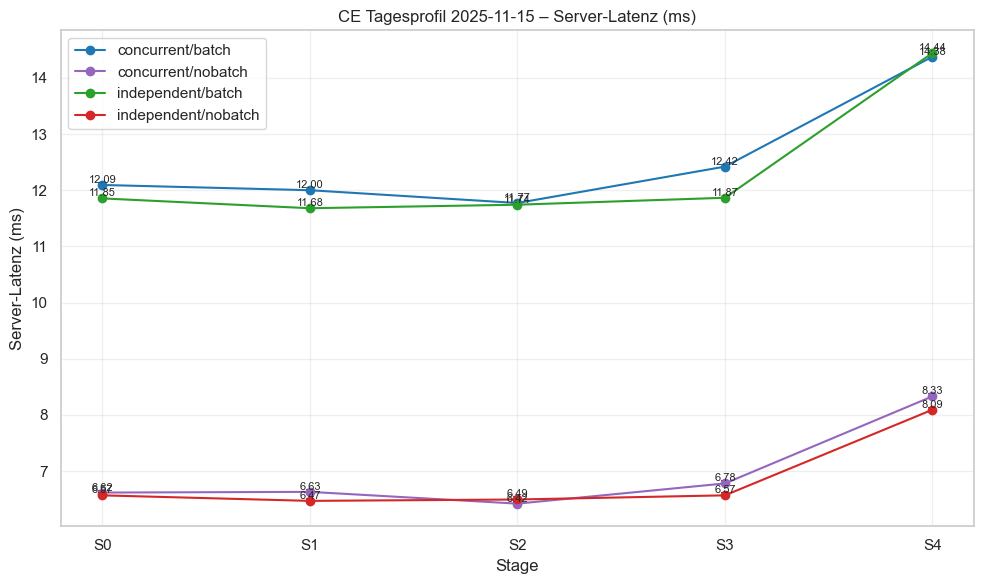

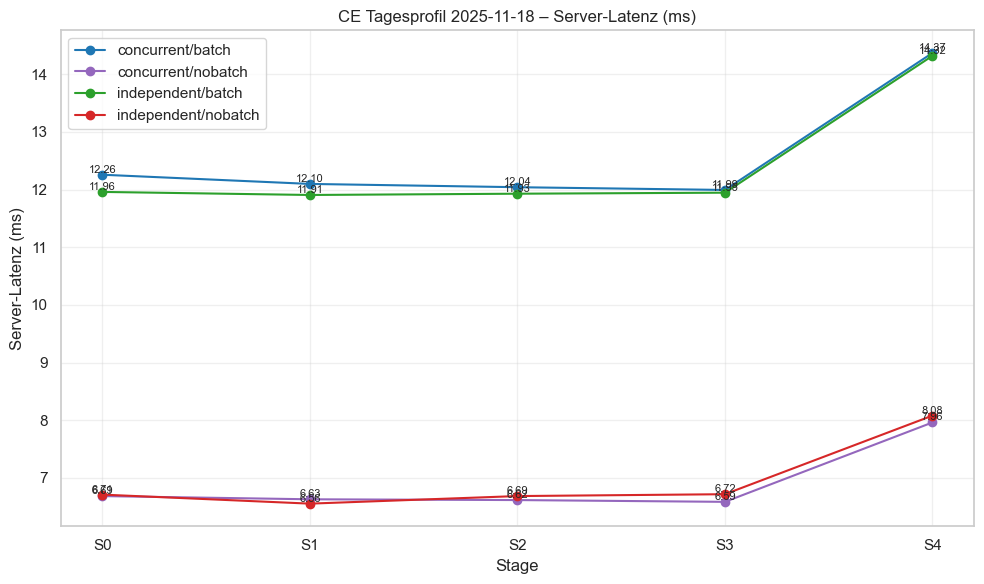

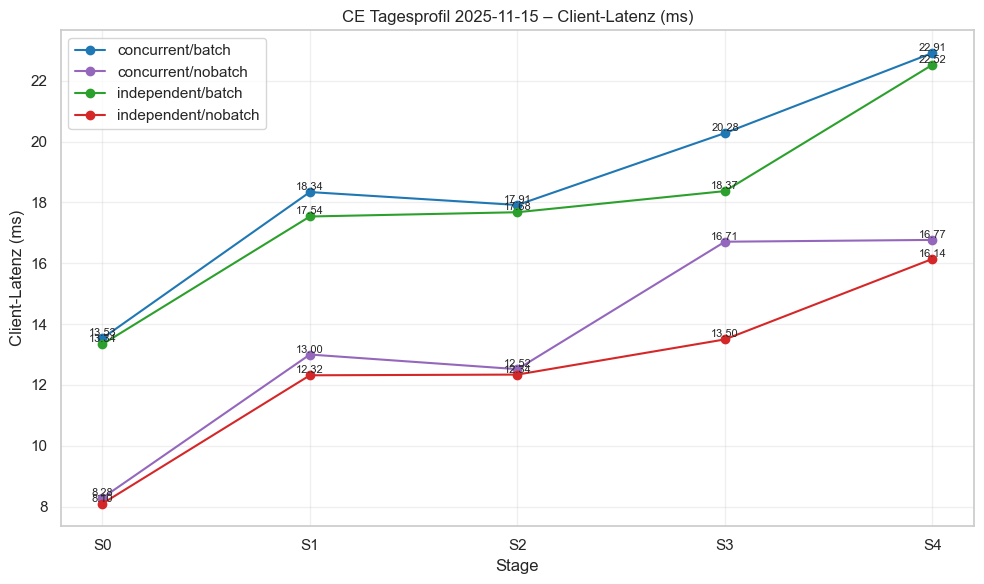

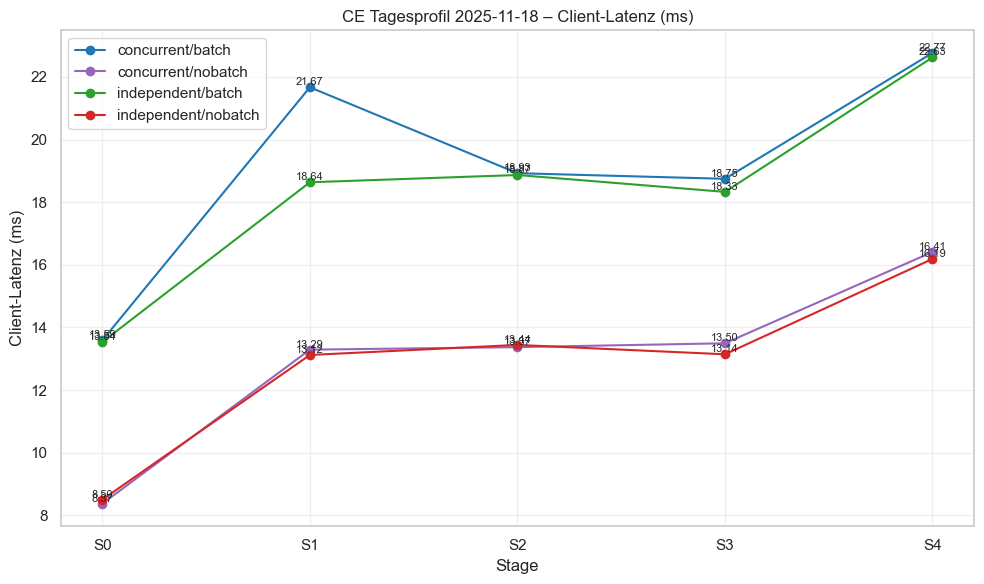

In [168]:

for day in complete_days:
    plot_ce_per_day_with_modes(lat, day, metric_col="server_latency_ms", metric_label="Server-Latenz (ms)")


for day in complete_days:
    plot_ce_per_day_with_modes(lat, day, metric_col="client_total_ms", metric_label="Client-Latenz (ms)")

